# Target Trial Emulation V2 in Python: Target Trial Emulation + Clustering

Target Trial Emulation is a new methodological framework in epidemiology which tries to account for the biases in old and traditional designs. This notebook extends the original Target Trial Emulation (TTE) framework by integrating a clustering mechanism on baseline characteristics. We then incorporate the cluster assignments into the marginal structural model (MSM) to explore whether treatment effects vary by subgroup.

Below, we provide insights of each step along with the implementation.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

## 1. Load Data and Overview

We load the dummy dataset (the file `data_censored.csv` should be in the same directory as this notebook). This dataset contains columns such as `id`, `period`, `treatment`, several covariates (`x1`, `x2`, etc.), `age`, `outcome`, `censored`, and `eligible`.

In [2]:
# Load the dummy data
data = pd.read_csv('..\data\data_censored.csv')
print('Data shape:', data.shape)
data.head()

Data shape: (725, 12)


,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible
0,1,0,1,1,1.146148,0,0.734203,36,0.083333,0,0,1
1,1,1,1,1,0.002200,0,0.734203,37,0.166667,0,0,0
2,1,2,1,0,-0.481762,0,0.734203,38,0.250000,0,0,0
3,1,3,1,0,0.007872,0,0.734203,39,0.333333,0,0,0
4,1,4,1,1,0.216054,0,0.734203,40,0.416667,0,0,0


## 2. Data Preparation

We replicate the preparation steps from the original TTE notebook:

- **Sort by `id` and `period`** for consistent ordering.
- **`prev_treatment`**: Shift the `treatment` column by one period within each `id`.
- **`assigned_treatment`**: The treatment at baseline (first period) for each `id`.
- **`trial_period`**: The minimum period for each `id` (used as a reference).
- **`followup_time`**: The difference between the current period and the baseline period.

In [3]:
# Sort by id, period
data = data.sort_values(by=['id', 'period']).reset_index(drop=True)

# Create 'prev_treatment' by grouping by id and shifting the 'treatment' column
data['prev_treatment'] = data.groupby('id')['treatment'].shift(1)

# Create 'assigned_treatment' as the treatment at baseline for each id
baseline = data.groupby('id')['period'].transform('min')
data['trial_period'] = baseline
data['assigned_treatment'] = data.groupby('id')['treatment'].transform('first')

# Define follow-up time
data['followup_time'] = data['period'] - data['trial_period']

print('Prepared data:')
data.head(10)

Prepared data:


,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible,prev_treatment,trial_period,assigned_treatment,followup_time
0,1,0,1,1,1.146148,0,0.734203,36,0.083333,0,0,1,NaN,0,1,0
1,1,1,1,1,0.002200,0,0.734203,37,0.166667,0,0,0,1.0,0,1,1
2,1,2,1,0,-0.481762,0,0.734203,38,0.250000,0,0,0,1.0,0,1,2
3,1,3,1,0,0.007872,0,0.734203,39,0.333333,0,0,0,1.0,0,1,3
4,1,4,1,1,0.216054,0,0.734203,40,0.416667,0,0,0,1.0,0,1,4
5,1,5,1,0,-0.057482,0,0.734203,41,0.500000,0,1,0,1.0,0,1,5
6,2,0,0,1,-0.802142,0,-0.990794,26,-0.750000,0,0,1,NaN,0,0,0
7,2,1,1,1,-0.983030,0,-0.990794,27,-0.666667,0,0,1,0.0,0,0,1
8,2,2,1,0,0.399388,0,-0.990794,28,-0.583333,0,0,0,1.0,0,0,2
9,2,3,0,0,1.835085,0,-0.990794,29,-0.500000,0,0,0,1.0,0,0,3


## 2A. Integrate Clustering on Baseline Characteristics
 We introduce a clustering step to identify latent subgroups in the study population. Here’s our approach:
 1. **Select** baseline features (e.g., `age`, `x1`, `x2`).
 2. **Standardize** them for clustering.
 3. **Cluster** using KMeans (with an example of 2 clusters).
 4. **Assign** each patient to a cluster and store in a new column `cluster`.

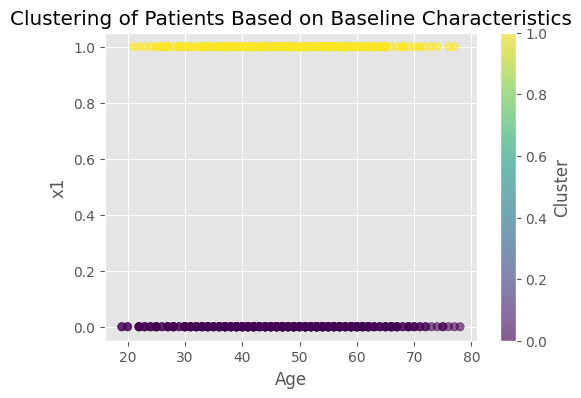

Cluster counts:
cluster
0    431
1    294
Name: count, dtype: int64


In [4]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select baseline features for clustering
baseline_features = data[['age', 'x1', 'x2']]

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(baseline_features)

# Run KMeans clustering (e.g., 2 clusters for demonstration)
kmeans = KMeans(n_clusters=2, random_state=42)
data['cluster'] = kmeans.fit_predict(features_scaled)

plt.figure(figsize=(6, 4))
plt.scatter(data['age'], data['x1'], c=data['cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('Age')
plt.ylabel('x1')
plt.title('Clustering of Patients Based on Baseline Characteristics')
plt.colorbar(label='Cluster')
plt.show()

print("Cluster counts:")
print(data['cluster'].value_counts())

## 3. Define Functions to Compute Weights

We keep the same approach to computing:

1. **Treatment Switching Weights:**  
   - **Numerator Model:** Predicts the probability of receiving the treatment using only a subset of covariates (here, using `age`).
   - **Denominator Model:** Uses a richer set of covariates (here, `age + x1 + x3`).
   - We compute the stabilized weight as the ratio of the numerator probability to the denominator probability.
   - For the baseline period (when no previous treatment is available) we set the weight to 1.

2. **Censoring Weights:**  
   - The outcome of interest here is the probability of not being censored. We create a new variable (`not_censored`) which is `1 - censored`.
   - Numerator model: `not_censored ~ x2`
   - Denominator model: `not_censored ~ x2 + x1`

Then the overall stabilized weight is the product of the two. In a more advanced approach, we could also incorporate cluster membership into these models.

In [5]:
def compute_stabilized_weight_switching(df):
    """
    Compute treatment switching stabilized weights.
    For observations with period > 0 (i.e. where a previous treatment exists),
    we compute the predicted probability using two models:
      - Numerator: treatment ~ age
      - Denominator: treatment ~ age + x1 + x3
    The stabilized weight is: p_numerator / p_denominator
    For period == 0, we set the weight = 1.
    """
    weights = []
    for idx, row in df.iterrows():
        if pd.isna(row['prev_treatment']) or row['period'] == 0:
            weights.append(1.0)
        else:
            sub_df = df[df['period'] > 0]
            
            # Numerator model
            try:
                num_model = smf.glm(
                    formula='treatment ~ age',
                    data=sub_df,
                    family=sm.families.Binomial()
                ).fit()
                p_num = num_model.predict(row)[0]
            except:
                p_num = 1.0
            
            # Denominator model
            try:
                denom_model = smf.glm(
                    formula='treatment ~ age + x1 + x3',
                    data=sub_df,
                    family=sm.families.Binomial()
                ).fit()
                p_denom = denom_model.predict(row)[0]
            except:
                p_denom = 1.0
            
            weight = p_num / p_denom if p_denom != 0 else 1.0
            weights.append(weight)
    
    return np.array(weights)

def compute_stabilized_weight_censoring(df):
    """
    Compute censoring weights. We define 'not_censored' = 1 - censored.
    Then fit:
       - Numerator: not_censored ~ x2
       - Denominator: not_censored ~ x2 + x1
    Stabilized weight = p_num / p_denom
    """
    df = df.copy()
    df['not_censored'] = 1 - df['censored']
    
    # Fit numerator model
    num_model = smf.glm(
        formula='not_censored ~ x2',
        data=df,
        family=sm.families.Binomial()
    ).fit()
    
    # Fit denominator model
    denom_model = smf.glm(
        formula='not_censored ~ x2 + x1',
        data=df,
        family=sm.families.Binomial()
    ).fit()
    
    p_num = num_model.predict(df)
    p_denom = denom_model.predict(df)
    
    weight = np.where(p_denom == 0, 1.0, p_num / p_denom)
    return weight

# Compute weights
data['w_switch'] = compute_stabilized_weight_switching(data)
data['w_censor'] = compute_stabilized_weight_censoring(data)
data['wt'] = data['w_switch'] * data['w_censor']

print('Weights computed:')
data[['id', 'period', 'w_switch', 'w_censor', 'wt']].head(10)

Weights computed:


,id,period,w_switch,w_censor,wt
0,1,0,1.0,0.955481,0.955481
1,1,1,1.0,0.970647,0.970647
2,1,2,1.0,1.016972,1.016972
3,1,3,1.0,1.021899,1.021899
4,1,4,1.0,0.968208,0.968208
5,1,5,1.0,1.021173,1.021173
6,2,0,1.0,0.978403,0.978403
7,2,1,1.0,0.979868,0.979868
8,2,2,1.0,1.026743,1.026743
9,2,3,1.0,1.053732,1.053732


## 4. Fitting the Outcome Model

We fit a marginal structural model (MSM) via weighted logistic regression. In **TTE-v2**, we now **include the cluster assignment** (`C(cluster)`) as an additional covariate to capture subgroup differences.

**Outcome Model Formula** (including cluster):

 outcome ~ assigned_treatment + C(cluster) + x2 + followup_time + followup_time_sq + trial_period + trial_period_sq

In [6]:
# Create polynomial terms
data['followup_time_sq'] = data['followup_time'] ** 2
data['trial_period_sq'] = data['trial_period'] ** 2

# Weighted logistic regression
outcome_formula_v2 = (
    'outcome ~ assigned_treatment + C(cluster) + x2 + '
    'followup_time + followup_time_sq + trial_period + trial_period_sq'
)

msm_model_v2 = smf.glm(
    formula=outcome_formula_v2,
    data=data,
    family=sm.families.Binomial(),
    freq_weights=data['wt']
).fit()

print(msm_model_v2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                  725
Model:                            GLM   Df Residuals:                   719.60
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -54.404
Date:                Sun, 09 Mar 2025   Deviance:                       108.81
Time:                        19:38:34   Pearson chi2:                     671.
No. Iterations:                     8   Pseudo R-squ. (CS):           0.006678
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -5.2313      0

## 5. Prediction and Plotting Survival Probability

As before, we generate predictions for different values of `assigned_treatment` across a range of follow-up times. However, we can also fix or vary `cluster` in these predictions. For a general overview, we’ll first **fix a single cluster** and compute survival differences. Then we’ll do a **cluster-stratified** analysis in **Step 5A**. Here we:

- Define a new dataframe with follow-up times from 0 to 10.
- Assume a fixed (average) value for covariate `x2` and a fixed `trial_period` (here set to 0 for simplicity).
- Generate predictions for each treatment group (assigned_treatment = 0 and 1).
- Convert the predicted probability of the outcome to a survival probability (i.e. `survival = 1 - predicted risk`).
- Compute the difference in survival between treatment groups and plot it over time.

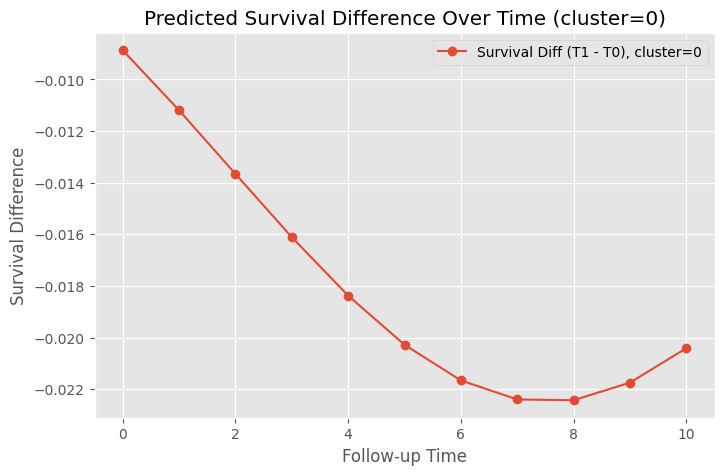

In [7]:
# Define a range of follow-up times
followup_range = np.arange(0, 11)

# Assume average x2 value from the data
avg_x2 = data['x2'].mean()

# Create prediction data for each treatment group (assign cluster=0 for demonstration)
def create_pred_df(assigned_treatment, cluster=0, trial_period=0):
    df_pred = pd.DataFrame({
        'assigned_treatment': assigned_treatment,
        'cluster': cluster,
        'x2': avg_x2,
        'followup_time': followup_range,
        'trial_period': trial_period
    })
    df_pred['followup_time_sq'] = df_pred['followup_time'] ** 2
    df_pred['trial_period_sq'] = df_pred['trial_period'] ** 2
    return df_pred

pred_df_t1 = create_pred_df(assigned_treatment=1, cluster=0)
pred_df_t0 = create_pred_df(assigned_treatment=0, cluster=0)

# Predicted probabilities (risk)
pred_risk_t1 = msm_model_v2.predict(pred_df_t1)
pred_risk_t0 = msm_model_v2.predict(pred_df_t0)

# Convert to survival probabilities
surv_t1 = 1 - pred_risk_t1
surv_t0 = 1 - pred_risk_t0

# Survival difference: T1 - T0
surv_diff = surv_t1 - surv_t0

# Plot
plt.figure(figsize=(8, 5))
plt.plot(followup_range, surv_diff, marker='o', label='Survival Diff (T1 - T0), cluster=0')
plt.xlabel('Follow-up Time')
plt.ylabel('Survival Difference')
plt.title('Predicted Survival Difference Over Time (cluster=0)')
plt.legend()
plt.show()

## 5A. Cluster-Stratified Predictions
Now, we can see if survival differences vary by cluster. Let’s generate predictions for both clusters (0 and 1, in this example) and plot them.

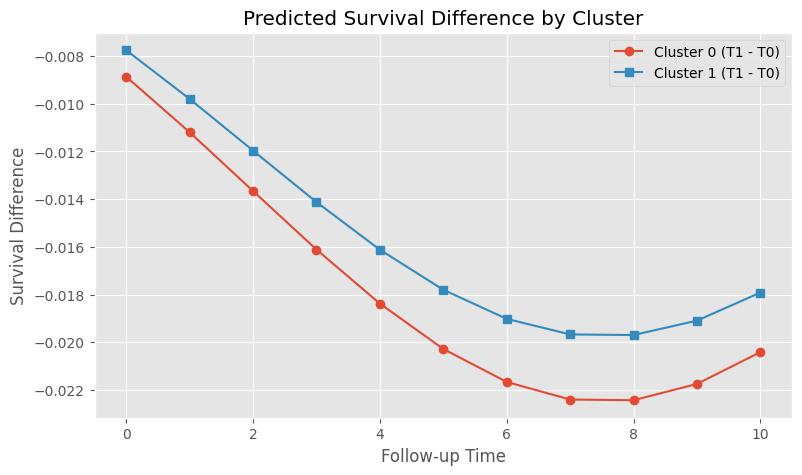

In [8]:
# Create a function to generate predictions for each cluster
def create_pred_df_with_cluster(assigned_treatment, cluster, trial_period=0):
    df_pred = pd.DataFrame({
        'assigned_treatment': assigned_treatment,
        'cluster': cluster,
        'x2': avg_x2,
        'followup_time': followup_range,
        'trial_period': trial_period
    })
    df_pred['followup_time_sq'] = df_pred['followup_time'] ** 2
    df_pred['trial_period_sq'] = df_pred['trial_period'] ** 2
    return df_pred

# Build prediction DataFrames for cluster=0 and cluster=1
pred_df_t1_c0 = create_pred_df_with_cluster(assigned_treatment=1, cluster=0)
pred_df_t0_c0 = create_pred_df_with_cluster(assigned_treatment=0, cluster=0)
pred_df_t1_c1 = create_pred_df_with_cluster(assigned_treatment=1, cluster=1)
pred_df_t0_c1 = create_pred_df_with_cluster(assigned_treatment=0, cluster=1)

# Predict risk
pred_risk_t1_c0 = msm_model_v2.predict(pred_df_t1_c0)
pred_risk_t0_c0 = msm_model_v2.predict(pred_df_t0_c0)
pred_risk_t1_c1 = msm_model_v2.predict(pred_df_t1_c1)
pred_risk_t0_c1 = msm_model_v2.predict(pred_df_t0_c1)

# Convert to survival
surv_t1_c0 = 1 - pred_risk_t1_c0
surv_t0_c0 = 1 - pred_risk_t0_c0
surv_t1_c1 = 1 - pred_risk_t1_c1
surv_t0_c1 = 1 - pred_risk_t0_c1

# Compute survival differences
surv_diff_c0 = surv_t1_c0 - surv_t0_c0
surv_diff_c1 = surv_t1_c1 - surv_t0_c1

# Plot both
plt.figure(figsize=(9, 5))
plt.plot(followup_range, surv_diff_c0, marker='o', label='Cluster 0 (T1 - T0)')
plt.plot(followup_range, surv_diff_c1, marker='s', label='Cluster 1 (T1 - T0)')
plt.xlabel('Follow-up Time')
plt.ylabel('Survival Difference')
plt.title('Predicted Survival Difference by Cluster')
plt.legend()
plt.show()


In this notebook, we did:

- **Clustering Integration**: By adding a clustering step on baseline characteristics, we can explore **latent subgroups** in the study population.
- **Subgroup Analysis**: Including `C(cluster)` in the outcome model helps us see whether the effect of treatment (e.g., the survival difference) is **consistent** or **heterogeneous** across different clusters.

**Potential Extensions**:     
1. Incorporate cluster membership in the **weighting models** (e.g., use cluster as a covariate in the numerator/denominator for treatment switching or censoring).    
2. Experiment with different clustering algorithms (e.g., hierarchical, DBSCAN) or different numbers of clusters.     
3. Perform **cluster-specific** model fits to see if the treatment effect differs more dramatically across subgroups.

This completes the **TTE-v2** workflow which illustrates how unsupervised learning (clustering) can enrich the target trial emulation approach.